## Dataset Preparation
I am about to extract features from the dataset sound using MFCC, and then fit it in a json file,

In [10]:
#import dataset related packages

import librosa
import os
import json

panjang_sampel = 22050*1 # sampling rate, remember nyquist theorem (default is 44100 hz so half of it?) * 1 means one second
panjang_sampel

22050

In [11]:
def preprocess_dataset(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512):

    data = {
        "mapping": [],
        "labels": [],
        "MFCCs": [],
        "files": []
    }
    count=0

    # loop through all sub-dirs
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're at sub-folder level
        if dirpath is not dataset_path:

            # save label (i.e., sub-folder name) in the mapping
            label = dirpath.split("/")[-1]
            data["mapping"].append(label)
            print("\nProcessing: '{}'".format(label))

            # process all audio files in sub-dir and store MFCCs
            for f in filenames:
                file_path = os.path.join(dirpath, f)

                # load audio file and slice it to ensure length consistency among different files
                signal, sample_rate = librosa.load(file_path)
            
                # drop audio files with less than pre-decided number of samples
                if len(signal) >= panjang_sampel:

                    # ensure consistency of the length of the signal
                    signal = signal[:panjang_sampel]

                    # extract MFCCs
                    MFCCs = librosa.feature.mfcc(y=signal,sr=sample_rate,n_mfcc=40)

                    # store data for analysed track
                    count=count+1
                    data["MFCCs"].append(MFCCs.T.tolist())
                    data["labels"].append(i-1)
                    data["files"].append(file_path)
                    print(str(count)+" {}: {}".format(file_path, i-1))

    # save data in json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


In [12]:
#Invoking the method to process the data for training
preprocess_dataset('dataset/train/', 'mixedformat.json')


Processing: 'domestic'
1 dataset/train/domestic\audio 101.ogg: 0
2 dataset/train/domestic\audio 103.ogg: 0
3 dataset/train/domestic\audio 104.ogg: 0
4 dataset/train/domestic\audio 105.ogg: 0
5 dataset/train/domestic\audio 106.ogg: 0
6 dataset/train/domestic\audio 107.ogg: 0
7 dataset/train/domestic\audio 109.ogg: 0
8 dataset/train/domestic\audio 110.ogg: 0
9 dataset/train/domestic\audio 111.ogg: 0
10 dataset/train/domestic\audio 112.ogg: 0
11 dataset/train/domestic\audio 118.ogg: 0
12 dataset/train/domestic\audio 120.ogg: 0
13 dataset/train/domestic\audio 19.ogg: 0
14 dataset/train/domestic\audio 21.ogg: 0
15 dataset/train/domestic\audio 23.ogg: 0
16 dataset/train/domestic\audio 24.ogg: 0
17 dataset/train/domestic\audio 25.ogg: 0
18 dataset/train/domestic\audio 26.ogg: 0
19 dataset/train/domestic\audio 27.ogg: 0
20 dataset/train/domestic\audio 29.ogg: 0
21 dataset/train/domestic\audio 32.ogg: 0
22 dataset/train/domestic\audio 38.ogg: 0
23 dataset/train/domestic\audio 59.ogg: 0
24 data

## Calling the json and training the model


In [13]:
#import training related packages

!pip3 install keras-visualizer

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_visualizer import visualizer

DATA_PATH = "mixedformat.json"
SAVED_MODEL_PATH = "training_mix_reajusted_input.h5"
EPOCHS = 100
BATCH_SIZE = 8
PATIENCE = 10
LEARNING_RATE = 0.0001

ModuleNotFoundError: No module named 'tensorflow.python'

In [11]:
def prepare_dataset(data_path, test_size=0.1, validation_size=0.1):
    # load dataset
    X, y = load_data(data_path)

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [13]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")
    return X, y

In [14]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.00001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    tf.keras.layers.Dropout(0.5)

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.00001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    tf.keras.layers.Dropout(0.2)

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.00001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    tf.keras.layers.Dropout(0.2)

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

In [15]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history

In [16]:
def plot_history(history):
    
    fig, axs = plt.subplots(2)

    plt.figure(figsize=(5,10))

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    

    plt.show()

In [17]:
X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

Training sets loaded!


In [18]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape, learning_rate=LEARNING_RATE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 38, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 42, 38, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 19, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 17, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 19, 17, 32)       128       
 hNormalization)                                                 
                                                        

In [19]:
print(X_train.shape)

print(input_shape)

(66, 44, 40, 1)
(44, 40, 1)


In [20]:
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

Epoch 1/100
9/9 [==============================] - 3s 73ms/step - loss: 3.2770 - accuracy: 0.1212 - val_loss: 6.4827 - val_accuracy: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 0s 27ms/step - loss: 1.7481 - accuracy: 0.3333 - val_loss: 3.0109 - val_accuracy: 0.2500
Epoch 3/100
9/9 [==============================] - 0s 29ms/step - loss: 1.1941 - accuracy: 0.5758 - val_loss: 2.1700 - val_accuracy: 0.2500
Epoch 4/100
9/9 [==============================] - 0s 28ms/step - loss: 0.9038 - accuracy: 0.6970 - val_loss: 1.9747 - val_accuracy: 0.3750
Epoch 5/100
9/9 [==============================] - 0s 27ms/step - loss: 0.6389 - accuracy: 0.8030 - val_loss: 1.8848 - val_accuracy: 0.5000
Epoch 6/100
9/9 [==============================] - 0s 28ms/step - loss: 0.5287 - accuracy: 0.8636 - val_loss: 1.7640 - val_accuracy: 0.5000
Epoch 7/100
9/9 [==============================] - 0s 31ms/step - loss: 0.5103 - accuracy: 0.8333 - val_loss: 1.5888 - val_accuracy: 0.5000
Epoch 8/100
9/9 

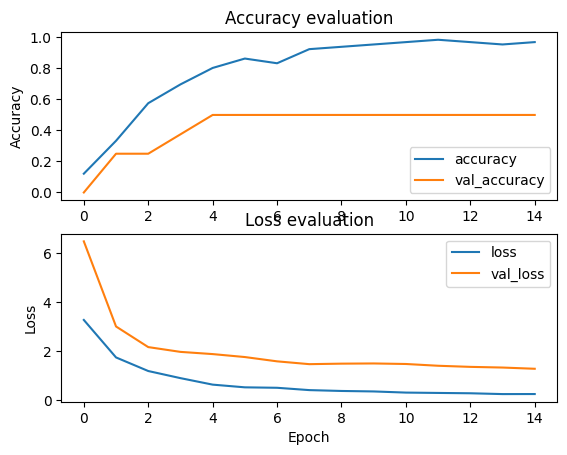

<Figure size 500x1000 with 0 Axes>

In [21]:
plot_history(history)

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 250ms/step - loss: 1.6499 - accuracy: 0.4444


In [17]:
test_loss

1.4639910459518433

In [18]:
test_acc

0.38461539149284363

In [23]:
model.save(SAVED_MODEL_PATH)

## Prediction 


In [24]:
#preprocess the input sample function
def preprocess(file_path, num_mfcc=13, n_fft=2048, hop_length=512):
        """Extract MFCCs from audio file.
        :param file_path (str): Path of audio file
        :param num_mfcc (int): # of coefficients to extract
        :param n_fft (int): Interval we consider to apply STFT. Measured in # of samples
        :param hop_length (int): Sliding window for STFT. Measured in # of samples
        :return MFCCs (ndarray): 2-dim array with MFCC data of shape (# time steps, # coefficients)
        """

        # load audio file
        signal, sample_rate = librosa.load(file_path)

        if len(signal) >= panjang_sampel:
            # ensure consistency of the length of the signal
            signal = signal[:panjang_sampel]

            # extract MFCCs
            MFCCs = librosa.feature.mfcc(y=signal,sr=sample_rate,n_mfcc=40)

        return MFCCs.T


In [25]:
loaded=tf.keras.models.load_model(SAVED_MODEL_PATH)

In [26]:
def predict(file_path):
       
        # extract MFCC
        MFCCs = preprocess(file_path)

        # we need a 4-dim array to feed to the model for prediction: (# samples, # time steps, # coefficients, 1)
        MFCCs = MFCCs[np.newaxis, ..., np.newaxis]

        # get the predicted label
        predictions = loaded.predict(MFCCs)

        return predictions

In [27]:
res=predict("dataset/train/physical/man-scream-03.wav")
res

1/1 [==============================] - 0s 251ms/step


array([[0.15914807, 0.53325284, 0.08405821, 0.22354086]], dtype=float32)

In [28]:
print("Prediksi Kekerasan: \n")
print("Domestik: "+str(res[0,0]*100)+"%")
print("Physical: "+str(res[0,1]*100)+"%")


Prediksi Kekerasan: 

Domestik: 15.914806723594666%
Physical: 53.32528352737427%
